In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from tensorflow.examples.tutorials.mnist import input_data
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Compute the time elapsed
"""
def tic():
    global tic_time
    tic_time = time.time()
    
def toc():
    return time.time() - tic_time

In [3]:
"""
Load MNIST data
Return: all 70000(train + val + test) images
"""
def load_data():
    mnist = input_data.read_data_sets('MNIST_data/')
    images = np.append(np.append(mnist.train.images, mnist.validation.images, axis=0), mnist.test.images, axis=0)
    return images #shape = (70000, 784)

In [4]:
"""
Define the Generator
"""
def generator(noises_input, n_1, n_2, n_3, n_out):
    with tf.variable_scope('generator'):
        Z1 = tf.contrib.layers.fully_connected(noises_input, n_1, activation_fn=None, scope='Z1')
        A1 = tf.nn.leaky_relu(Z1, name='A1')
        Z2 = tf.contrib.layers.fully_connected(A1, n_2, activation_fn=None, scope='Z2')
        A2 = tf.nn.leaky_relu(Z2, name='A2')
        Z3 = tf.contrib.layers.fully_connected(A2, n_3, activation_fn=None, scope='Z3')
        A3 = tf.nn.leaky_relu(Z3, name='A3')
        Z_out = tf.contrib.layers.fully_connected(A3, n_out, activation_fn=None, scope='Z_out')
        A_out = tf.nn.tanh(Z_out, name='A_out')
    return A_out

In [5]:
"""
Define the Discriminator
"""
def discriminator(images_input, n_1, n_2, n_3, n_out, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        Z1 = tf.contrib.layers.fully_connected(images_input, n_1, activation_fn=None, scope='Z1')
        A1 = tf.nn.leaky_relu(Z1, name='A1')
        A1_dropout = tf.nn.dropout(A1, 0.7, name='A1_dropout')
        Z2 = tf.contrib.layers.fully_connected(A1_dropout, n_2, activation_fn=None, scope='Z2')
        A2 = tf.nn.leaky_relu(Z2, name='A2')
        A2_dropout = tf.nn.dropout(A2, 0.7, name='A2_dropout')
        Z3 = tf.contrib.layers.fully_connected(A2_dropout, n_3, activation_fn=None, scope='Z3')
        A3 = tf.nn.leaky_relu(Z3, name='A3')
        A3_dropout = tf.nn.dropout(A3, 0.7, name='A3_dropout')
        Z_out = tf.contrib.layers.fully_connected(A3_dropout, n_out, activation_fn=None, scope='Z_out')
    return Z_out

In [6]:
"""
Define and Train Generative Adversarial Networks(GANs) Model
Return: history of costs(both generator and discriminator) 
        samples generated in each epoch
"""
def MNIST_GAN(hyperparams):
    tf.reset_default_graph()
    #Load data#
    mnist_images = load_data() * 2 - 1
    
    #Hyperparameters settings and properties#
    noise_size = hyperparams['noise_size']
    batch_size = hyperparams['batch_size']
    label_smooth = hyperparams['label_smooth']
    epoch = hyperparams['epoch']
    generator_n_1 = hyperparams['generator_n_1']
    generator_n_2 = hyperparams['generator_n_2']
    generator_n_3 = hyperparams['generator_n_3']
    generator_n_out = hyperparams['generator_n_out']
    discriminator_n_1 = hyperparams['discriminator_n_1']
    discriminator_n_2 = hyperparams['discriminator_n_2']
    discriminator_n_3 = hyperparams['discriminator_n_3']
    discriminator_n_out = hyperparams['discriminator_n_out']
    gen_learning_rate = hyperparams['gen_learning_rate']
    dis_learning_rate = hyperparams['dis_learning_rate']
    adam_beta1 = hyperparams['adam_beta1']
    sample_size = hyperparams['sample_size']
    data_size = mnist_images.shape[0]
    image_size = mnist_images.shape[1]
    total_batches = np.ceil(data_size / batch_size).astype(np.int32)
    
    #Define placeholders#
    real_images = tf.placeholder(tf.float32, (None, image_size), name='real_images')
    noises_input = tf.placeholder(tf.float32, (None, noise_size), name='noises_input')
    
    #Define the outputs of generator and discriminator#
    fake_images = generator(noises_input, generator_n_1, generator_n_2, generator_n_3, generator_n_out)
    real_logits = discriminator(real_images, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_out)
    fake_logits = discriminator(fake_images, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_out, reuse=True)
    
    #Define costs of discriminator(fake and real data) and generator#
    dis_real_cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.subtract(tf.ones_like(real_logits), label_smooth)))
    dis_fake_cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    dis_cost = tf.divide(tf.add(dis_real_cost, dis_fake_cost), 2)
    gen_cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    
    #Define the optimization#
    trainable_vars = tf.trainable_variables()
    gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    dis_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    gen_optimize = tf.train.AdamOptimizer(learning_rate=gen_learning_rate, beta1=adam_beta1, name='gen_optimize').minimize(gen_cost, var_list=gen_vars)
    dis_optimize = tf.train.AdamOptimizer(learning_rate=dis_learning_rate, beta1=adam_beta1, name='dis_optimize').minimize(dis_cost, var_list=dis_vars)
    
    #Training#
    costs_history = []
    sample_images_generated = np.empty((0, sample_size, image_size))
    sample_noises_input = np.random.uniform(low=-1, high=1, size=(sample_size, noise_size))
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch):
            tic()
            dis_cost_real_epoch = 0.
            dis_cost_fake_epoch = 0.
            dis_cost_epoch = 0.
            gen_cost_epoch = 0.
            for j in range(total_batches):
                index_front = j * batch_size
                index_end = (j + 1) * batch_size if (j + 1) * batch_size < data_size else data_size
                images_batch = mnist_images[index_front:index_end].reshape(-1, image_size)
                noises_batch = np.random.uniform(low=-1, high=1, size=(index_end - index_front, noise_size))
                _, dis_cost_real_iter, dis_cost_fake_iter, dis_cost_iter = sess.run([dis_optimize, dis_real_cost, dis_fake_cost, dis_cost], feed_dict={real_images:images_batch, noises_input:noises_batch})
                _, gen_cost_iter = sess.run([gen_optimize, gen_cost], feed_dict={noises_input:noises_batch})
                dis_cost_real_epoch += dis_cost_real_iter / data_size
                dis_cost_fake_epoch += dis_cost_fake_iter / data_size
                dis_cost_epoch += dis_cost_iter / data_size
                gen_cost_epoch += gen_cost_iter / data_size
            costs_history.append((dis_cost_real_epoch, dis_cost_fake_epoch, dis_cost_epoch, gen_cost_epoch))
            sample_images_generated_epoch = sess.run(fake_images, feed_dict={noises_input:sample_noises_input}).reshape(1, -1, image_size)
            sample_images_generated = np.append(sample_images_generated, sample_images_generated_epoch, axis=0)
            print('Epoch {}/{} Time Elapsed: {:.2f}s'.format(i + 1, epoch, toc()))
            print('Discriminator Cost: {:.4f} (Real: {:.4f} + Fake: {:.4f}) Generator Cost: {:.4f}'.format(dis_cost_epoch, dis_cost_real_epoch, dis_cost_fake_epoch, gen_cost_epoch))
        return costs_history, sample_images_generated

In [7]:
"""
Show graphs of costs of discriminator and generator
"""
def show_graphs(costs_history):
    costs = np.array(costs_history).T
    plt.figure(figsize=(20, 10))
    plt.ylabel('Cost')
    plt.xlabel('Epoch')
    plt.title('Cost - Epoch')
    plt.plot(costs[0], label='Discriminator Real Cost')
    plt.plot(costs[1], label='Discriminator Fake Cost')
    plt.plot(costs[2], label='Discriminator Total Cost')
    plt.plot(costs[3], label='Generator Cost')
    plt.legend(loc='best')
    plt.show()

In [8]:
"""
Show and save samples
Variables: 
    sample_images_generated shape: (num of epochs, num of samples in each epoch, num of rows of image, num of column of image)
    save: True if want to save the figures(pngs and gifs)
    folder_name: create the folder if not exists, save figures to the specific folder
"""
def show_save_samples(sample_images_generated, save=False, folder_name='MNIST_GAN_samples', gif_frame_duration=0.25):
    #Scale images to the range of [0, 1]#
    sample_images_generated = (sample_images_generated + 1) / 2
    
    #Create folder if not exists#
    if save and not os.path.exists('./{}'.format(folder_name)):
        os.mkdir(folder_name)
        
    #Parameters#
    epochs = sample_images_generated.shape[0]
    num_sample_each_epoch = sample_images_generated.shape[1]
    
    #Output and save figures#
    for i in range(epochs):
        plt.figure(figsize=(2 * num_sample_each_epoch, 5))
        for j in range(num_sample_each_epoch):
            plt.subplot(1, num_sample_each_epoch, j + 1)
            plt.axis('off')
            plt.imshow(sample_images_generated[i, j].reshape(28, 28), cmap='gray')    
        plt.text(-169, 40, 'Epoch {}'.format(i + 1), fontsize=25) #adjust the text location
        if save:
            plt.savefig('./{}/{}.png'.format(folder_name, i + 1))
        plt.show()
        
    #Make GIF#
    if save:
        gif_frames = []
        for i in range(epochs):
            gif_frames.append(imageio.imread('./{}/{}.png'.format(folder_name, i + 1)))
        imageio.mimsave('./{}/evolution.gif'.format(folder_name), gif_frames, duration=gif_frame_duration)

In [9]:
"""
Define the hyperparameters
"""
hyperparams={
    'noise_size': 100,
    'batch_size': 128,
    'label_smooth': 0.1,
    'epoch': 100,
    'generator_n_1': 256,
    'generator_n_2': 512,
    'generator_n_3': 1024,
    'generator_n_out': 784,
    'discriminator_n_1': 1024,
    'discriminator_n_2': 512,
    'discriminator_n_3': 256,
    'discriminator_n_out': 1,
    'gen_learning_rate': 0.0001,
    'dis_learning_rate': 0.0001,
    'adam_beta1': 0.5,
    'sample_size': 10
}
costs_history, sample_images_generated = MNIST_GAN(hyperparams)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 1/100 Time Elapsed: 6.02s
Discriminator Cost: 0.4731 (Real: 0.4464 + Fake: 0.4999) Generator Cost: 1.4063
Epoch 2/100 Time Elapsed: 7.45s
Discriminator Cost: 0.3860 (Real: 0.5313 + Fake: 0.2406) Generator Cost: 2.4851
Epoch 3/100 Time Elapsed: 7.65s
Discriminator Cost: 0.3670 (Real: 0.5467 + Fake: 0.1874) Generator Cost: 2.6930
Epoch 4/100 Time Elapsed: 7.98s
Discriminator Cost: 0.3607 (Real: 0.5449 + Fake: 0.1766) Generator Cost: 2.7561
Epoch 5/100 Time Elapsed: 7.56s
Discriminator Cost: 0.3599 (Real: 0.5449 + Fake: 0.1749) Generator Cost: 2.7399
Epoch 6/100 Time Elapsed: 7.82s
Discriminator Cost: 0.3651 (Real: 0.5479 + Fake: 0.1822) Generator Cost: 2.7250
Epoch 7/100 Time Elapsed: 7.62s
Discriminator Cost: 0.3766 (Real: 0.5557 + Fake: 0.1975) Generator Cost: 2.7055
Epoch 8/100 Time Elaps

Epoch 72/100 Time Elapsed: 7.77s
Discriminator Cost: 0.5788 (Real: 0.7010 + Fake: 0.4566) Generator Cost: 1.3007
Epoch 73/100 Time Elapsed: 6.07s
Discriminator Cost: 0.5806 (Real: 0.7029 + Fake: 0.4583) Generator Cost: 1.2925
Epoch 74/100 Time Elapsed: 7.59s
Discriminator Cost: 0.5804 (Real: 0.7026 + Fake: 0.4582) Generator Cost: 1.2990
Epoch 75/100 Time Elapsed: 7.56s
Discriminator Cost: 0.5791 (Real: 0.7015 + Fake: 0.4567) Generator Cost: 1.2973
Epoch 76/100 Time Elapsed: 7.75s
Discriminator Cost: 0.5816 (Real: 0.7032 + Fake: 0.4600) Generator Cost: 1.2927
Epoch 77/100 Time Elapsed: 7.68s
Discriminator Cost: 0.5810 (Real: 0.7028 + Fake: 0.4591) Generator Cost: 1.2919
Epoch 78/100 Time Elapsed: 7.66s
Discriminator Cost: 0.5828 (Real: 0.7043 + Fake: 0.4612) Generator Cost: 1.2771
Epoch 79/100 Time Elapsed: 7.87s
Discriminator Cost: 0.5810 (Real: 0.7030 + Fake: 0.4590) Generator Cost: 1.2873
Epoch 80/100 Time Elapsed: 7.83s
Discriminator Cost: 0.5834 (Real: 0.7051 + Fake: 0.4618) Genera

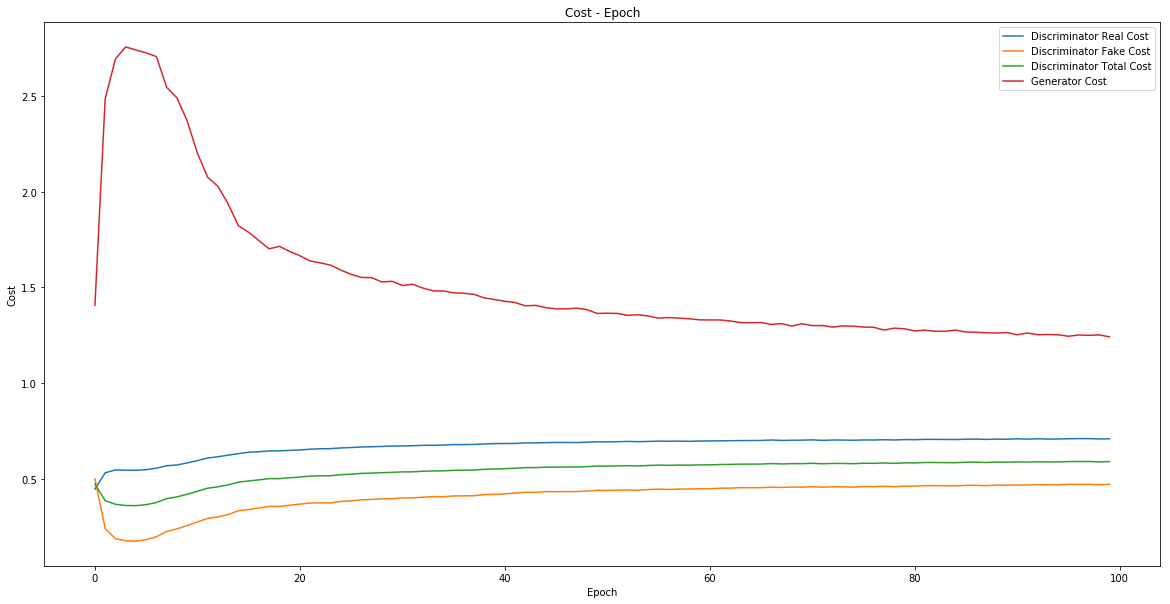

In [10]:
show_graphs(costs_history)

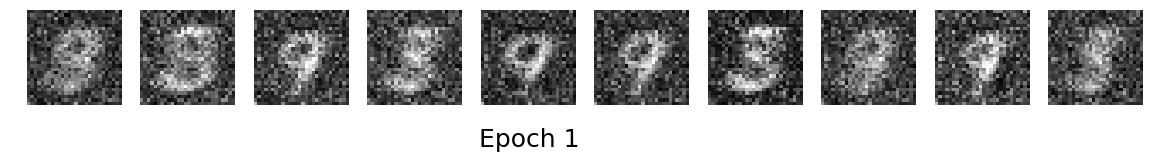

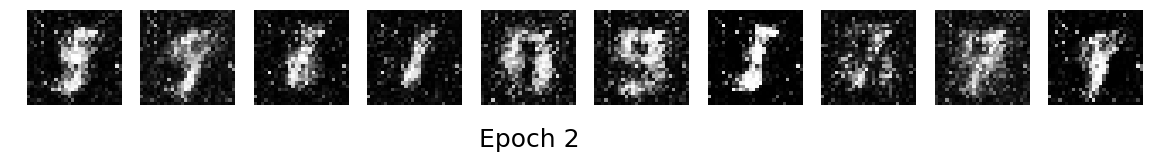

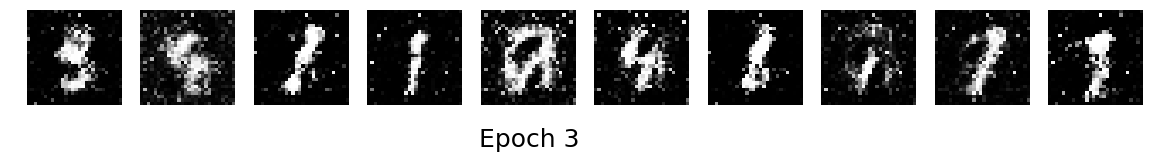

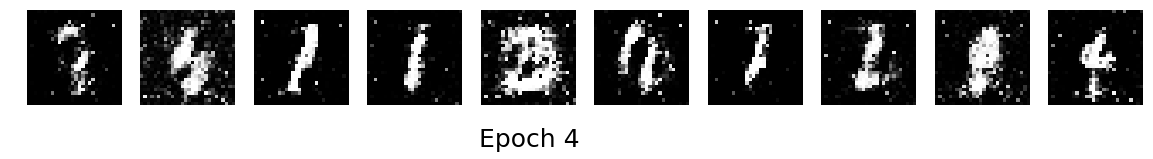

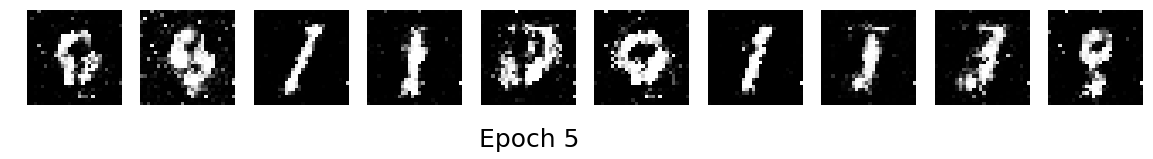

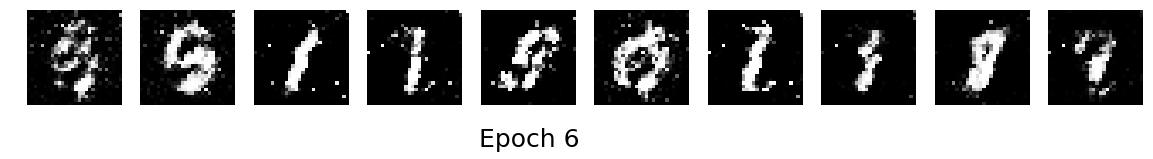

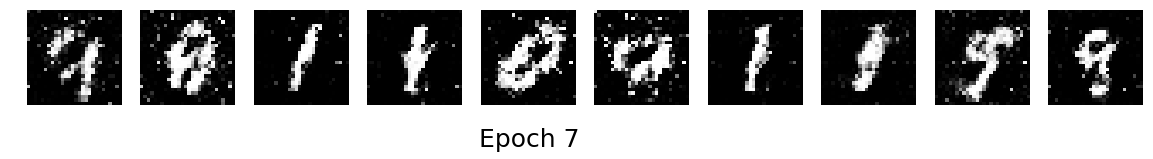

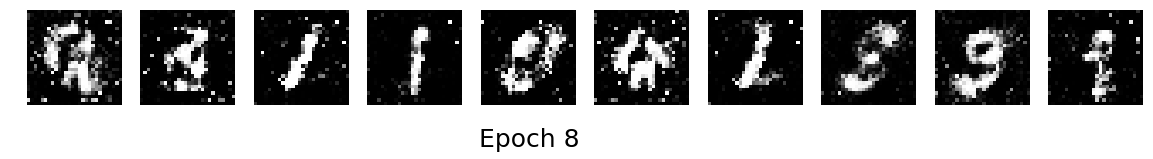

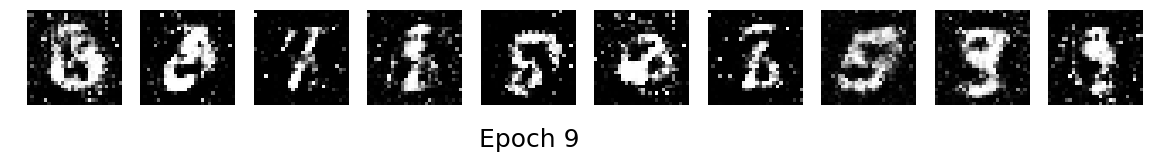

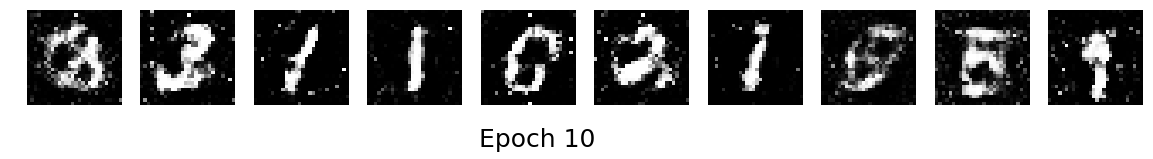

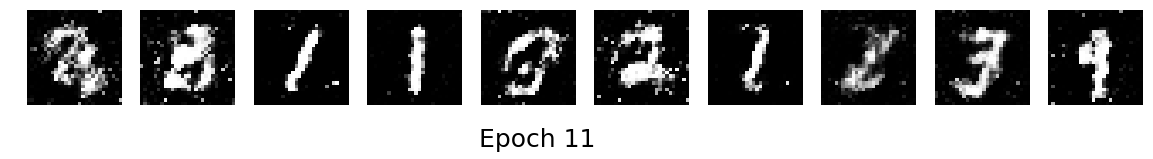

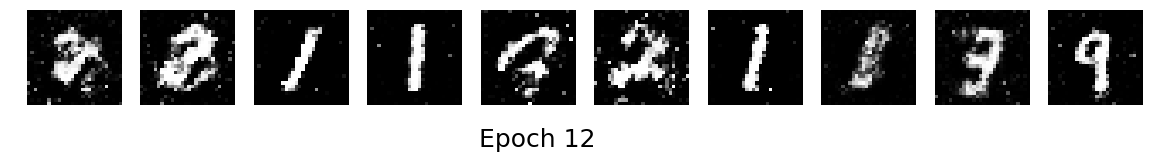

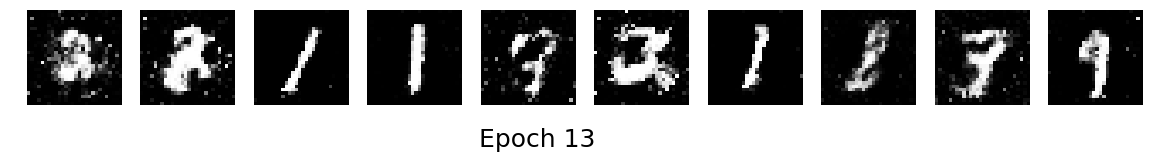

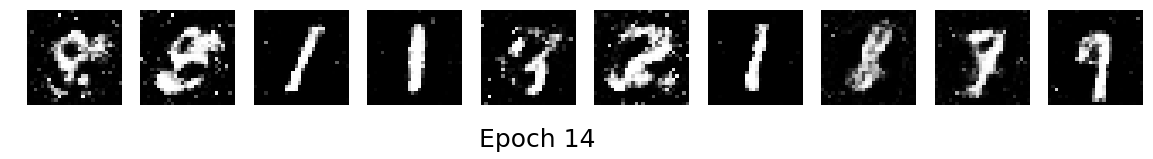

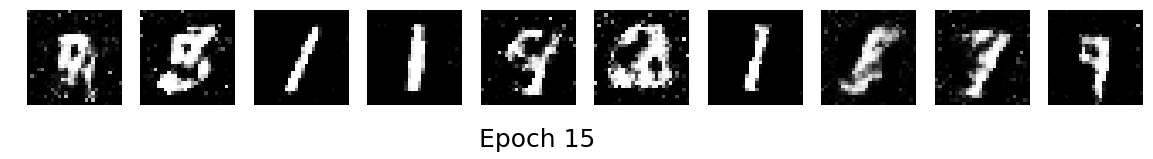

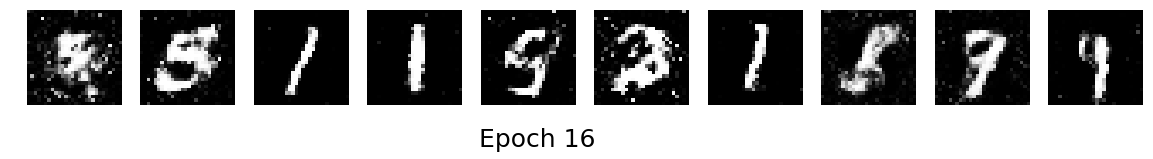

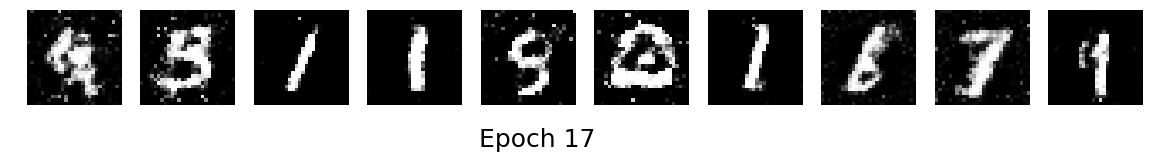

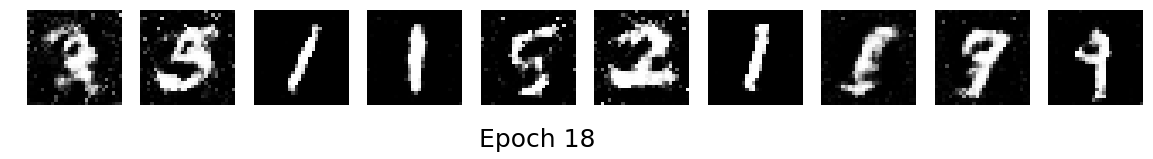

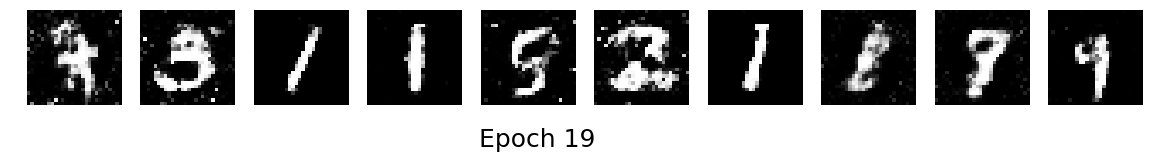

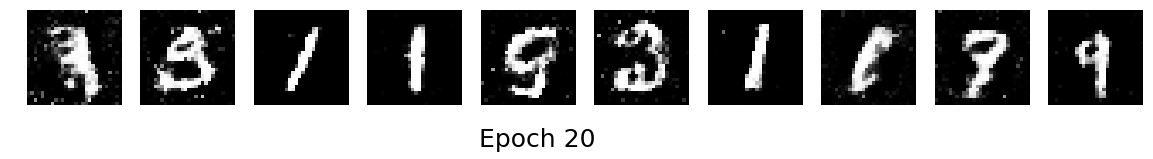

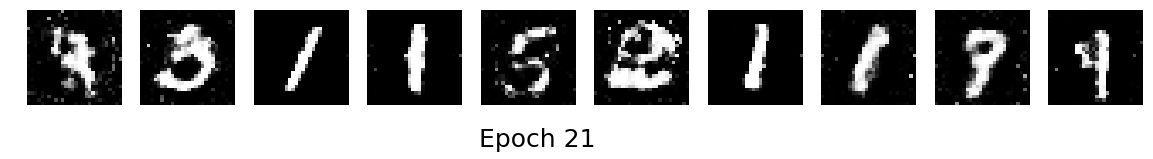

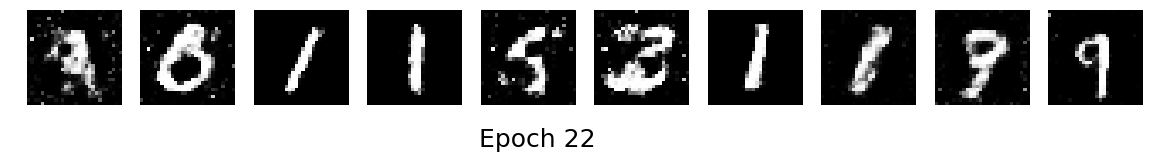

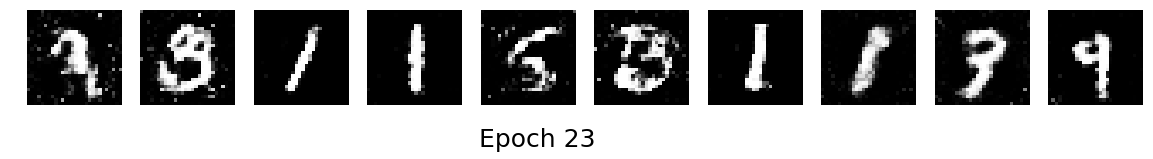

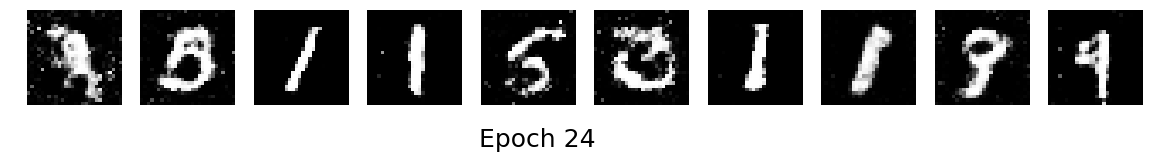

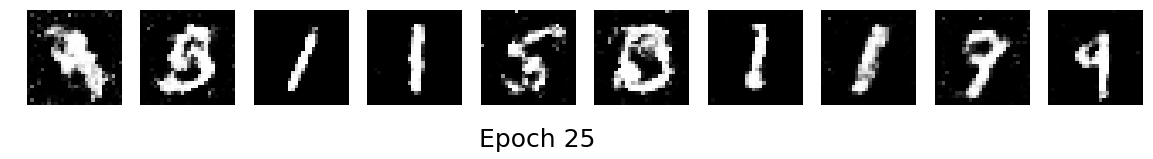

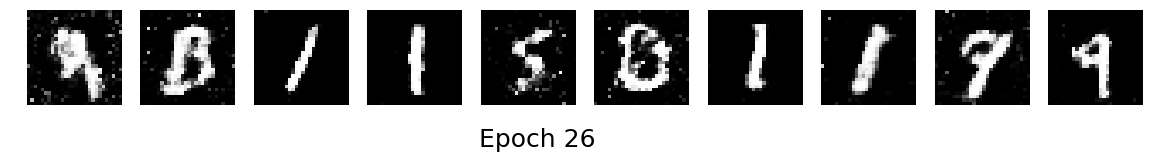

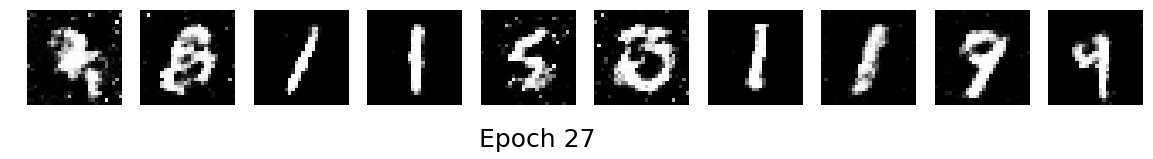

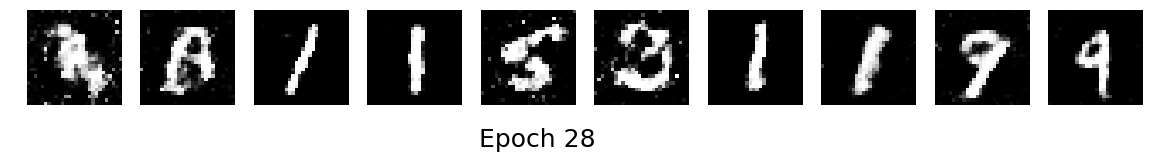

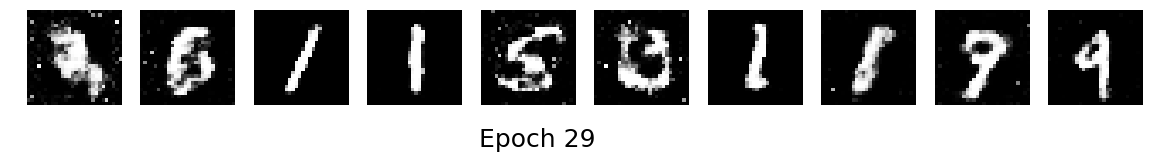

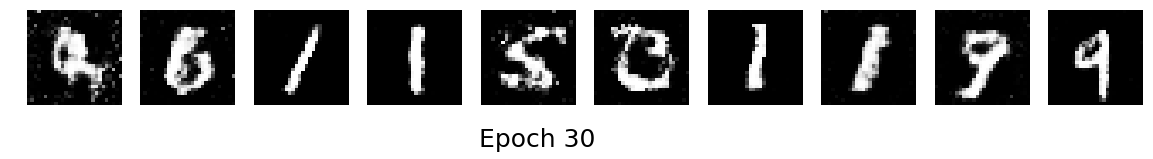

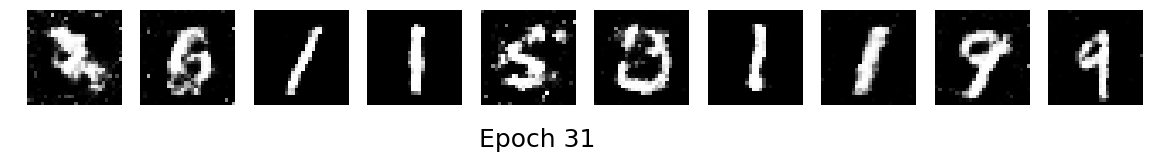

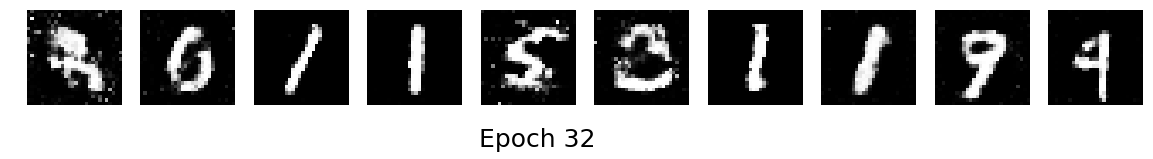

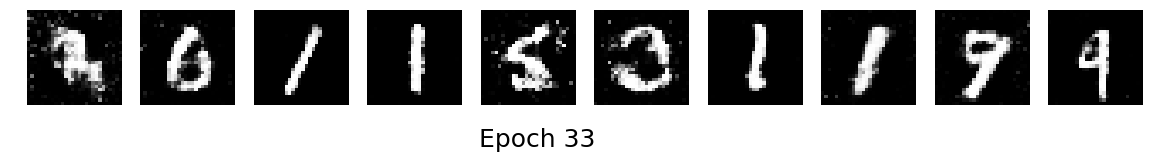

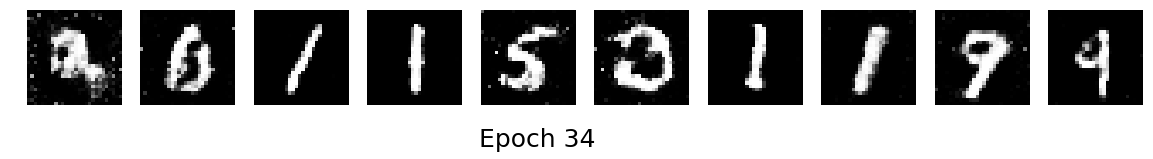

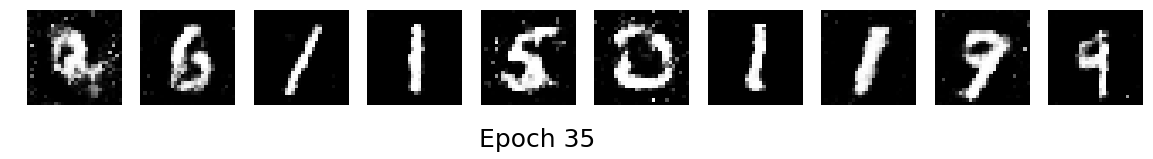

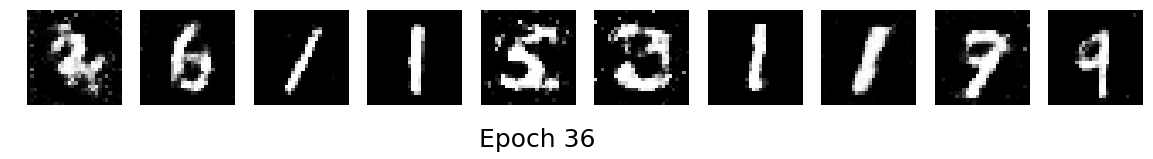

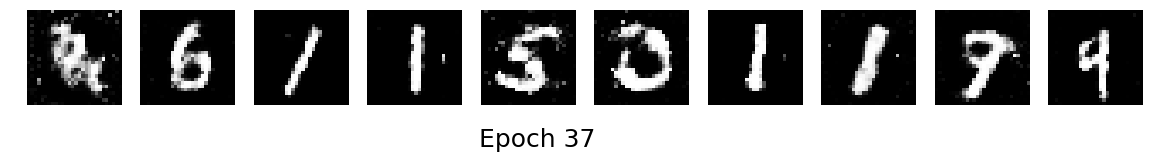

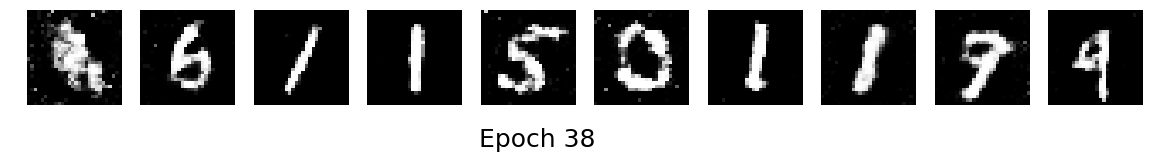

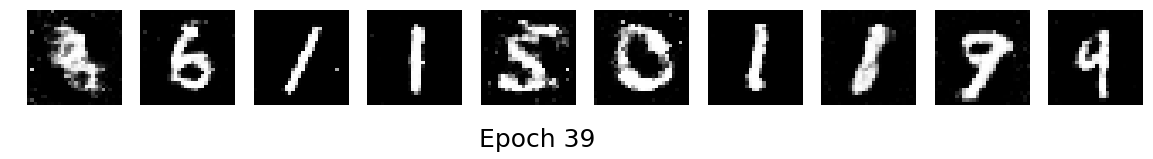

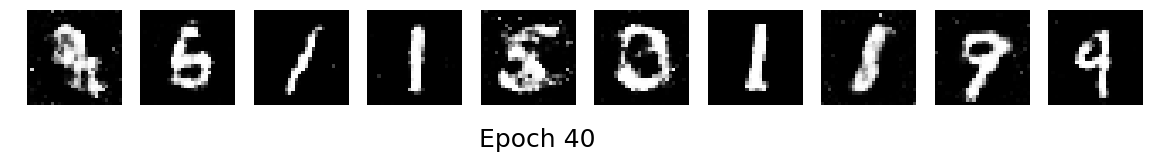

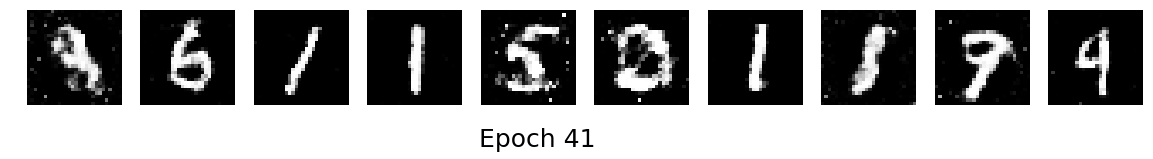

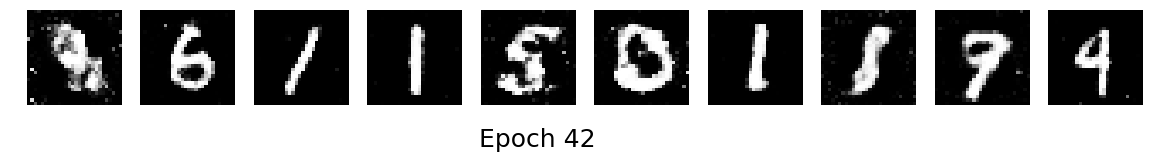

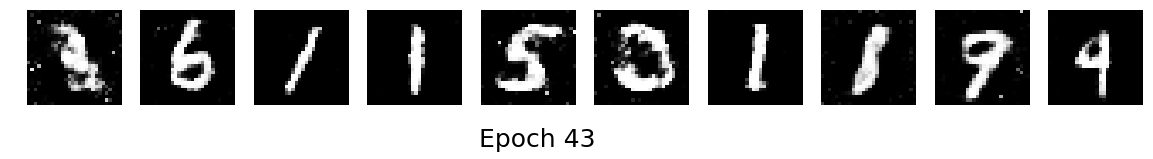

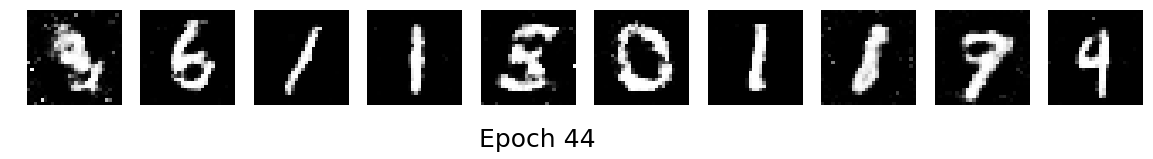

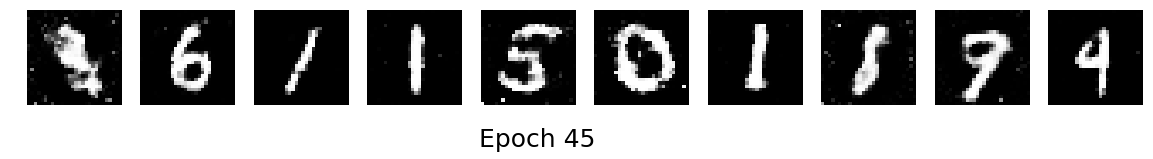

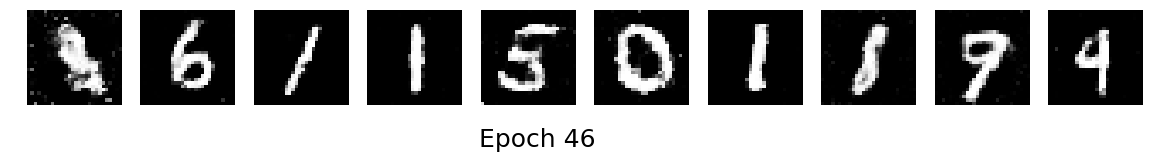

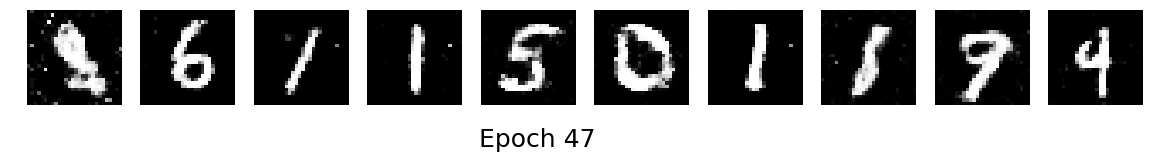

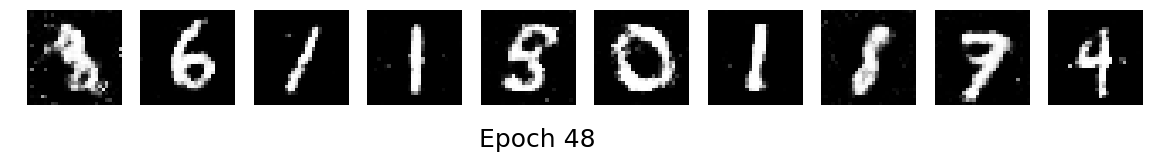

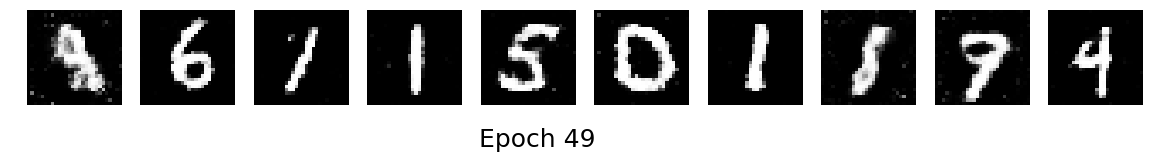

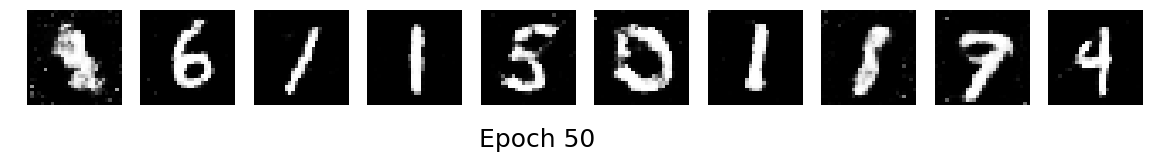

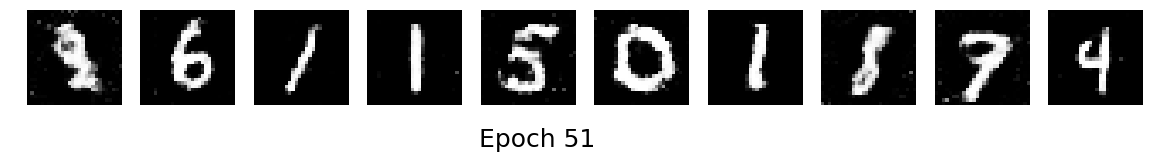

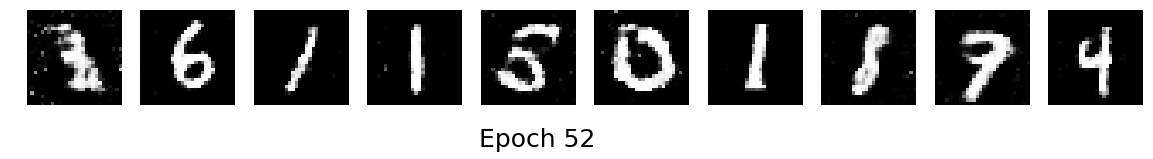

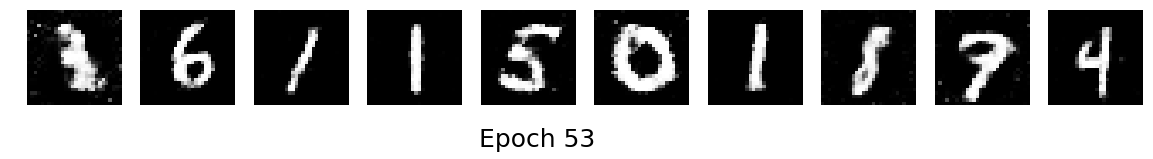

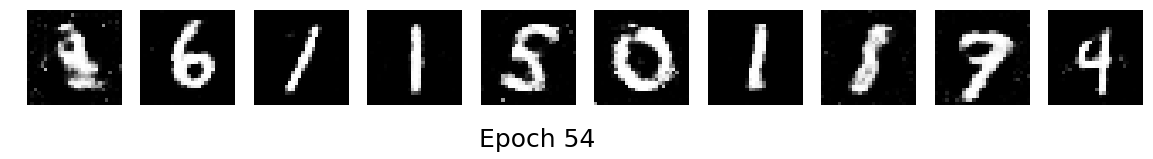

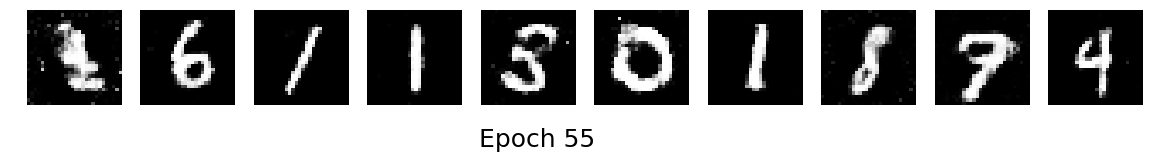

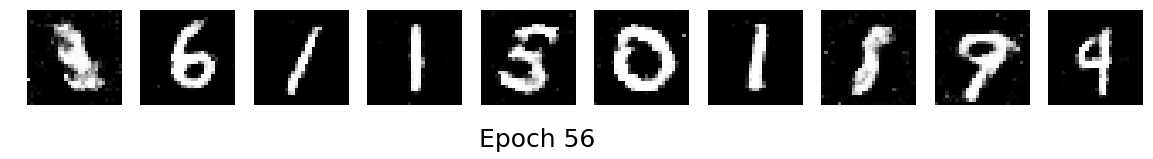

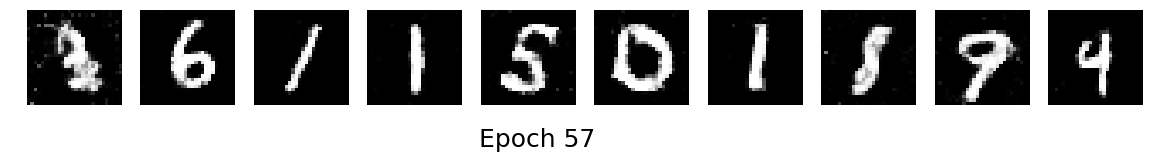

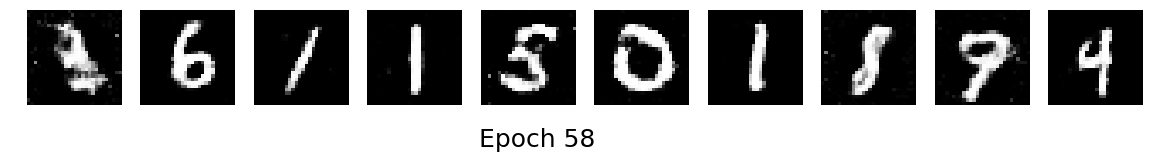

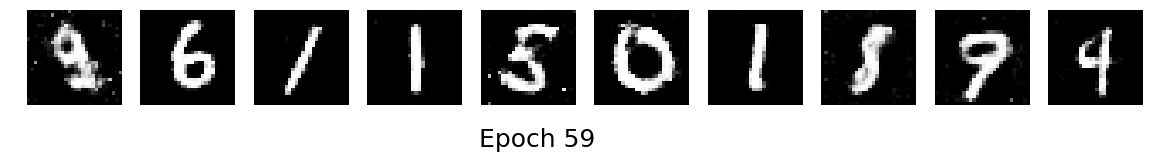

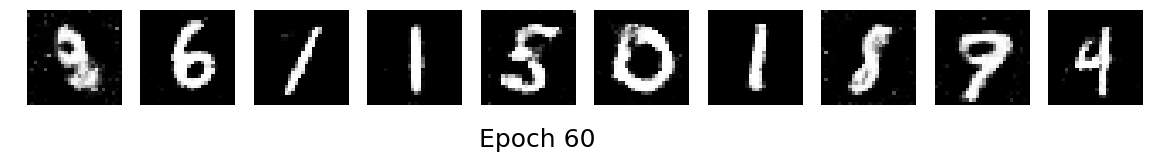

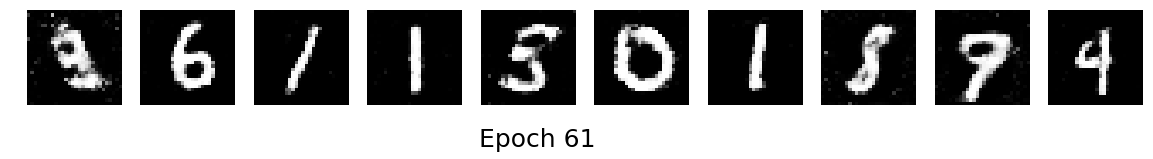

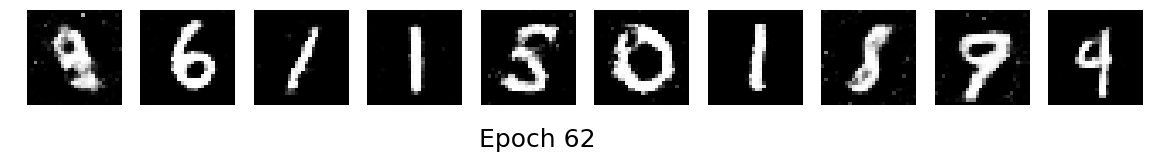

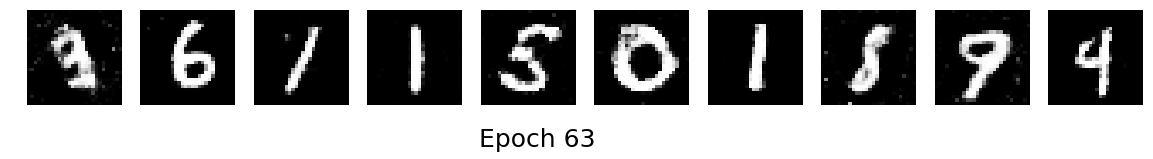

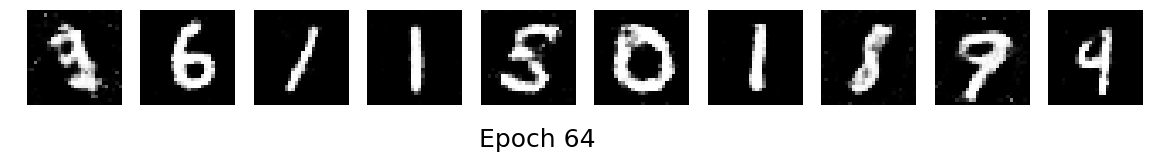

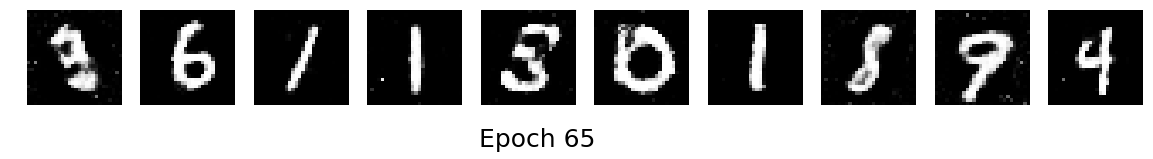

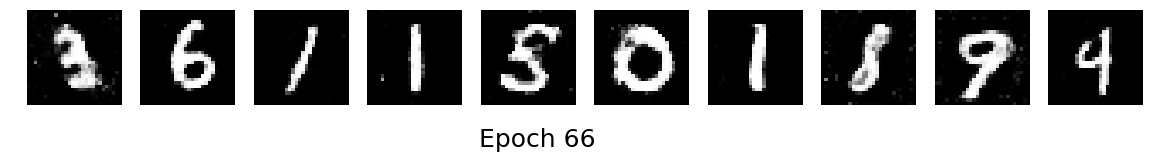

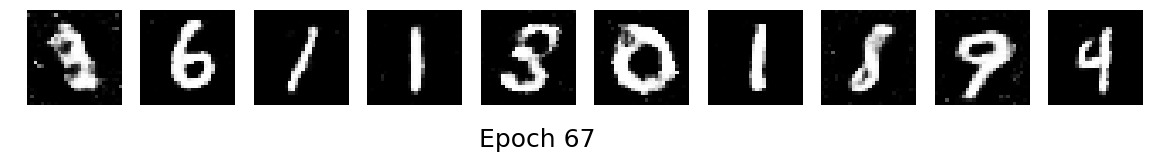

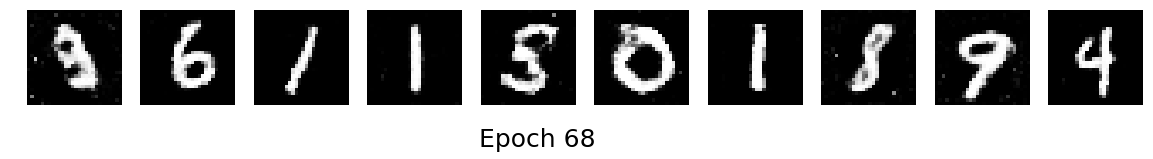

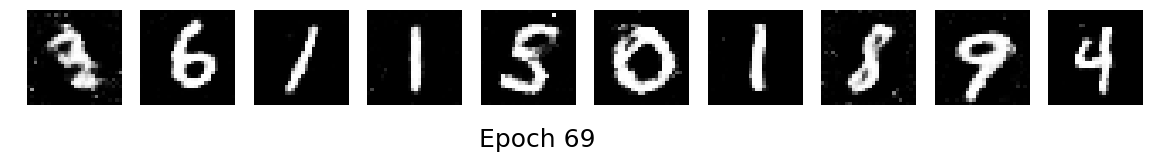

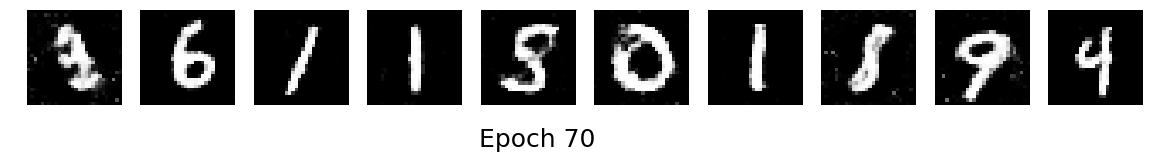

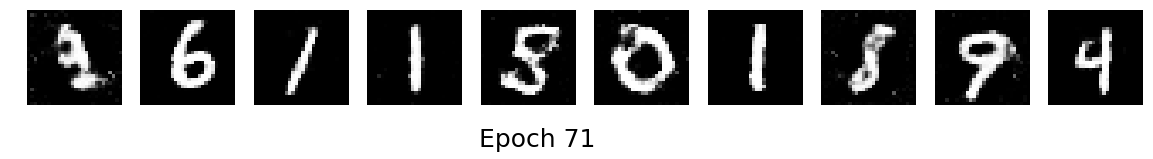

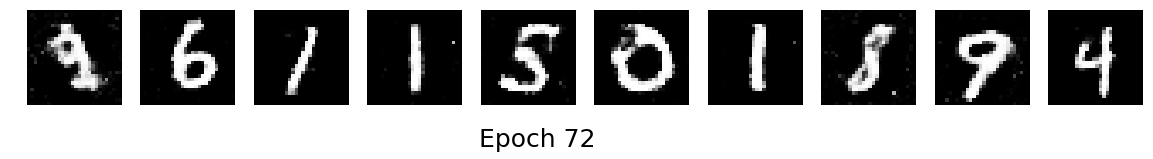

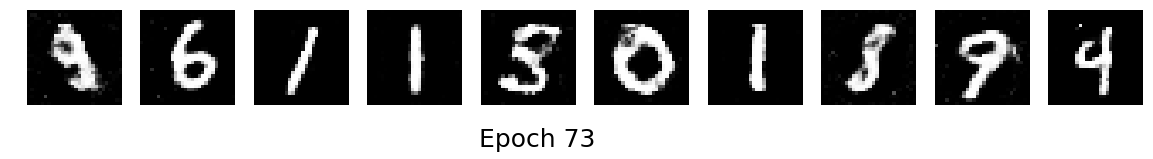

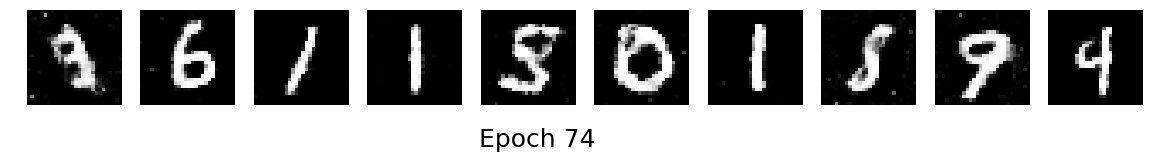

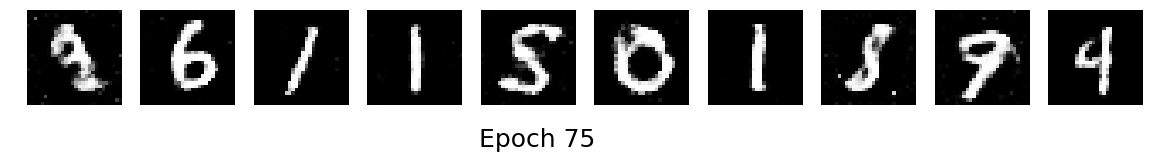

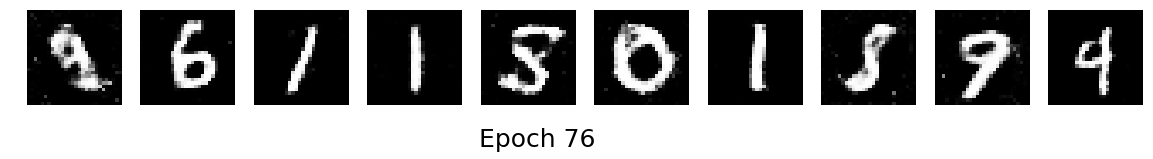

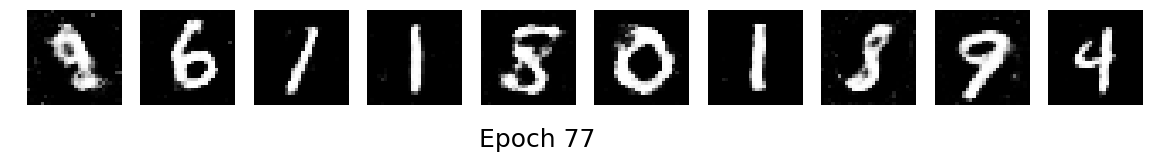

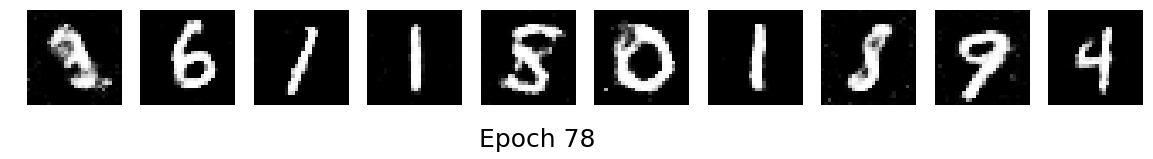

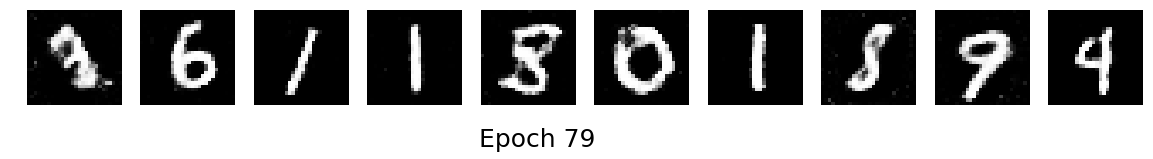

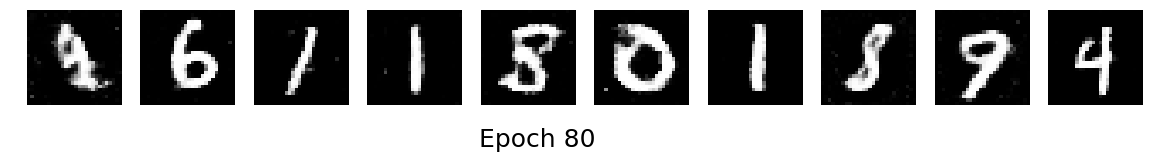

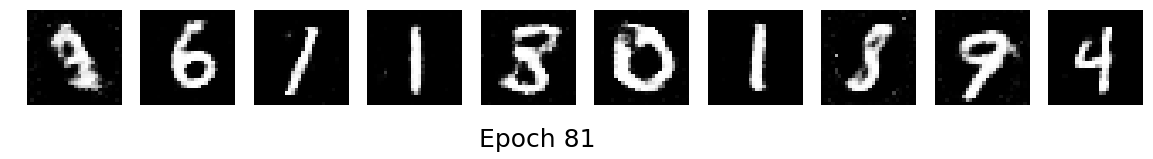

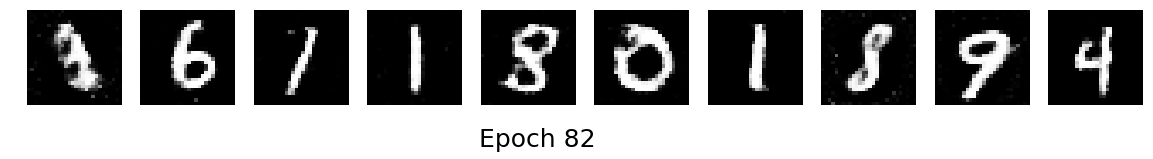

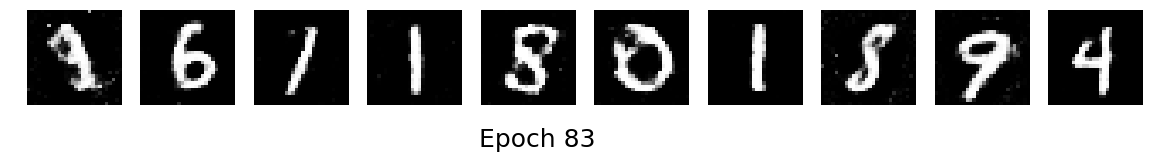

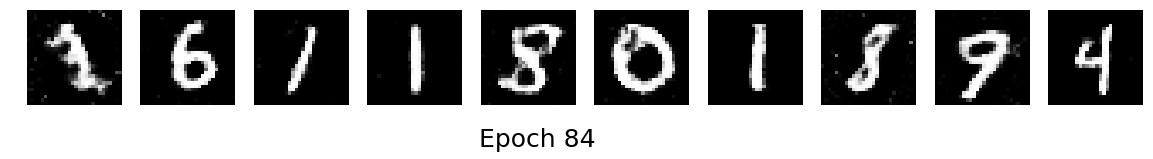

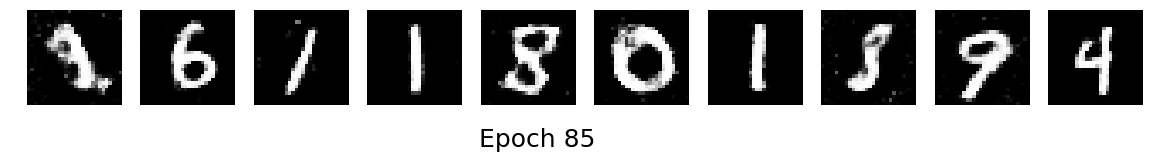

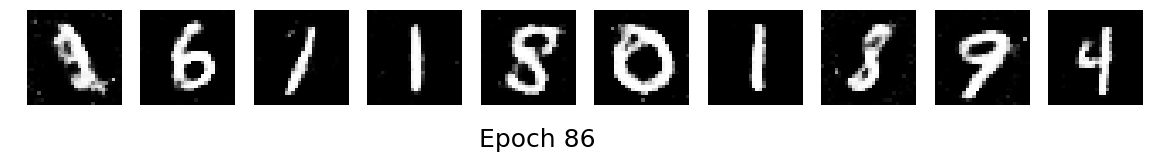

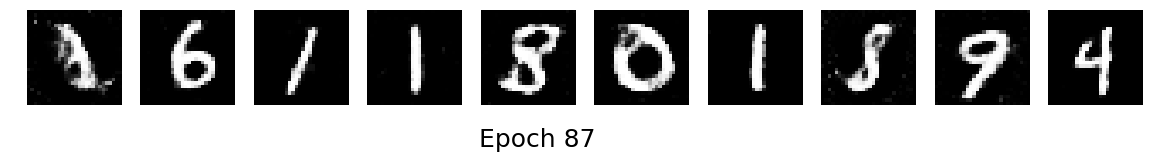

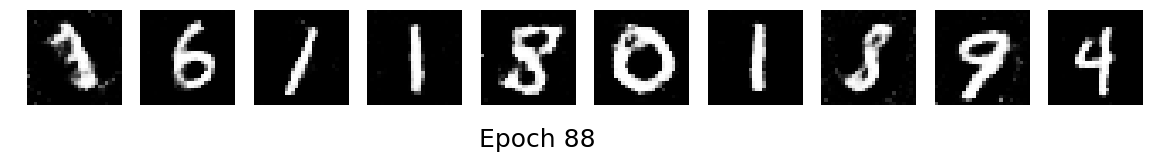

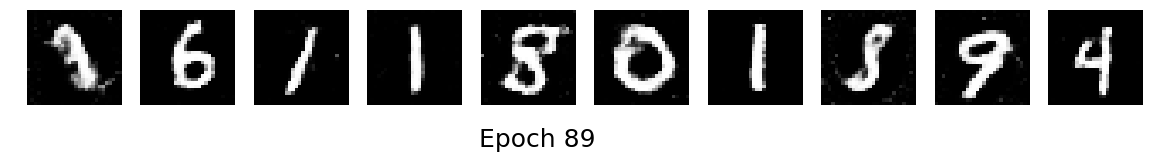

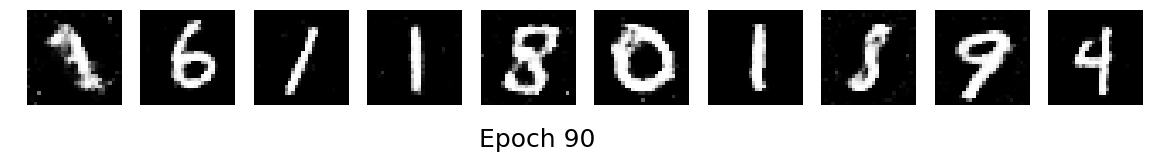

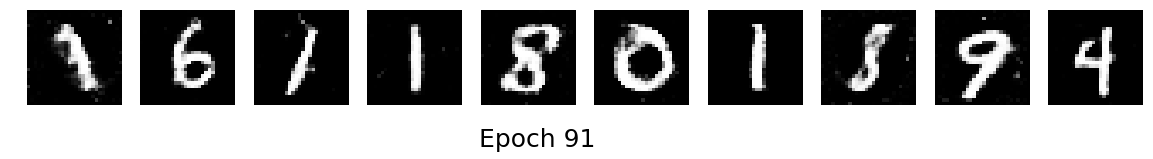

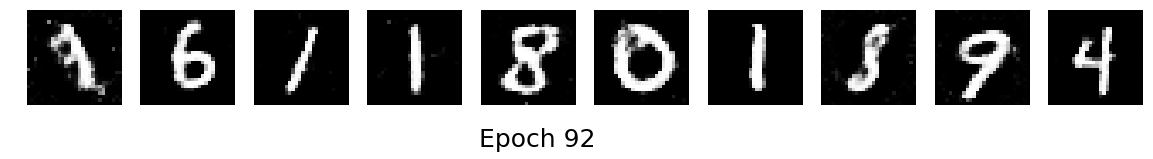

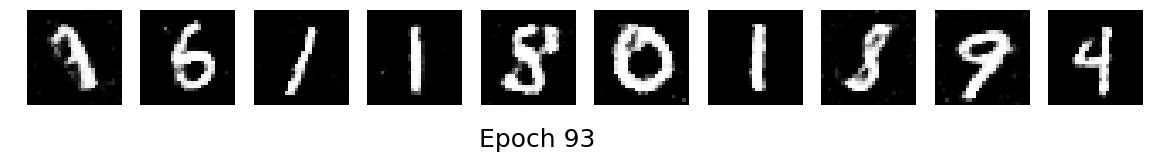

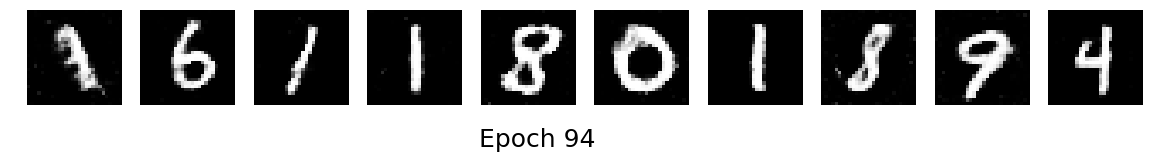

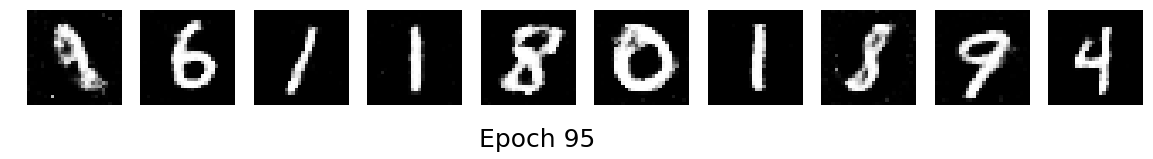

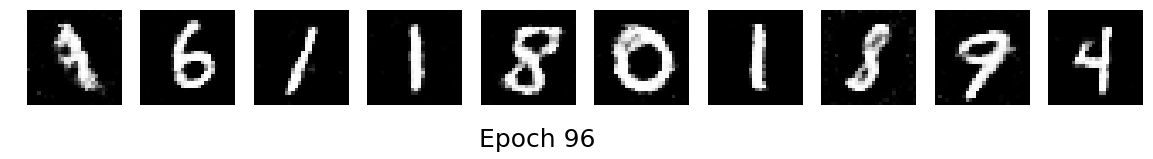

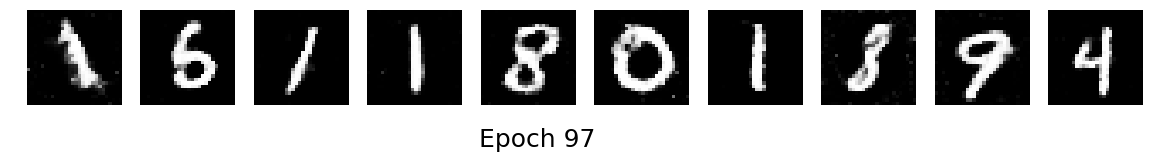

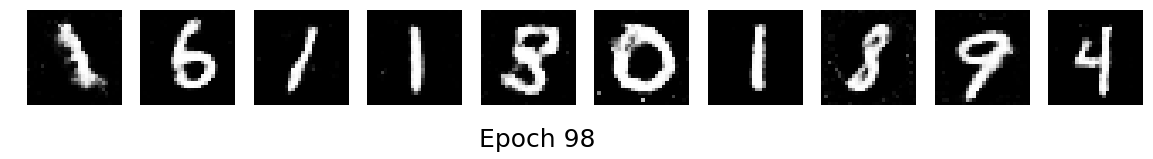

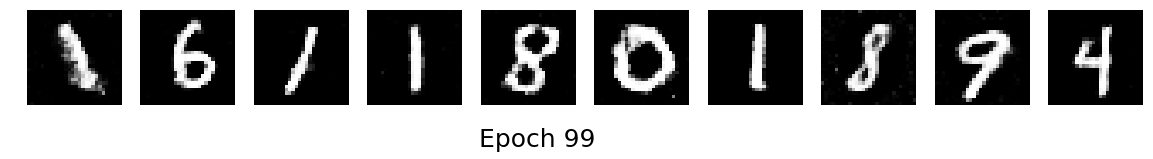

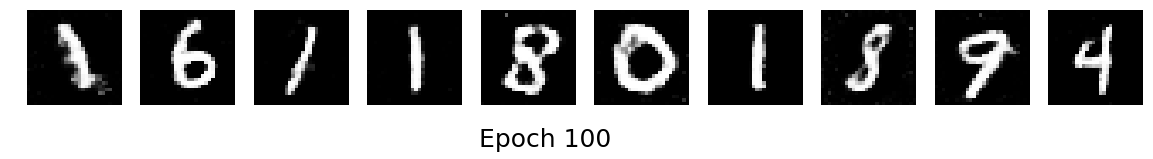

In [11]:
show_save_samples(sample_images_generated, save=True, gif_frame_duration=0.3)